In [329]:
# Data sourced from the St. Louis Fed (FRED) - https://fred.stlouisfed.org/series/RSXFS
# NOTE: data is on a monthly-basis and adjusted for seasonality

In [247]:
import pandas as pd
import datetime
import pandas.plotting as pd_plt
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import mlflow
from mlflow import MlflowClient
import mlflow.sklearn
from mlflow.models.signature import infer_signature

In [248]:
# Uncomment the below line and execute to set up the MLFlowUI, the link below can be used to access the UI in your browser
#! mlflow ui

#http://localhost:5000/

# Data Ingestion

In [317]:
file_path = 'retail_sales.csv'

df = pd.read_csv(file_path, names=['date', 'sales'], header=0)

df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = df.index.to_period('M')

df.head()

,sales
date,
1992-01,146925
1992-02,147223
1992-03,146805
1992-04,148032
1992-05,149010


# Plot Time-Series Data

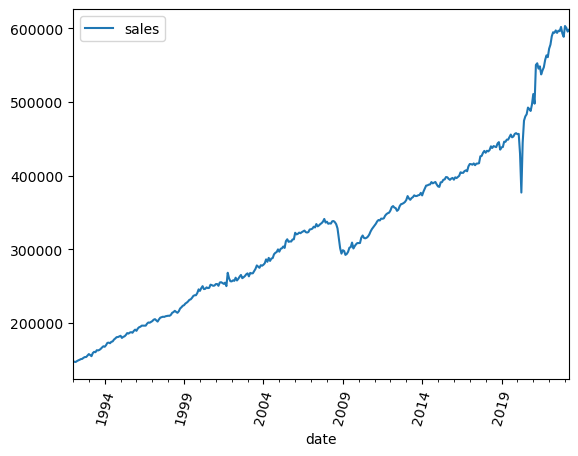

In [250]:
# plot monthly retail sales between 1993 and 2023
df.plot()
plt.xticks(rotation = 75)
plt.show()

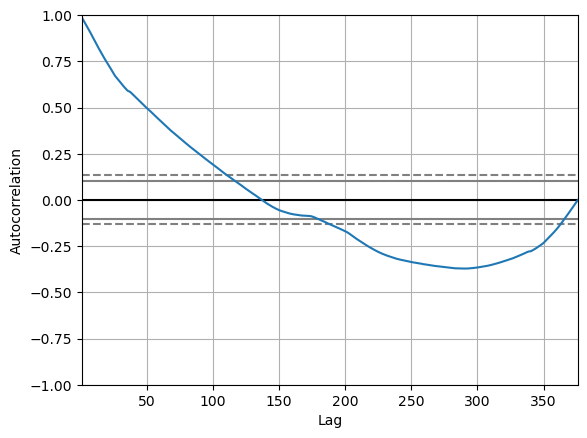

In [251]:
pd_plt.autocorrelation_plot(df)
plt.show()

# Feature Engineering and Pre-processing

In [257]:
# feature engineer lagged variables (5)
# dynamically create new field names

def get_lag_values(df):
    var_dict = {}
    for i in range(1,51):
        var_dict[f'{i}'] = f'sales_lag_{i}'

    for i, (k, v) in enumerate(var_dict.items()):
        df[v] = df['sales'].shift(int(k))
        
    return df

In [258]:
# get count before and after dropping records with nulls (t1-t49)
feature_engineered_df = get_lag_values(df)
feature_engineered_df.dropna(inplace=True)
df = feature_engineered_df.copy() 

print(len(df))
print(len(df))

326
326


In [259]:
# create training, testing split
# filter through 1999
df = df.iloc[:47, :]

x = np.array(df.drop(columns=['sales']).reset_index(drop=True))
y = np.array(df['sales'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)

# Random Forest Model

In [185]:
experiment_name='retail_sales_forecasting'
mlflow.set_experiment(experiment_name=experiment_name)

with mlflow.start_run(run_name='rf'):
    # modeling pipeline
    rf = RandomForestRegressor(random_state=42)
    rf.fit(x_train, y_train)

    # model scoring
    pred_df = rf.predict(x_test)
    rmse = sqrt(mean_squared_error(y_test, pred_df))
    print(f'RMSE: {rmse}')

    # log run with MLFlow
    mlflow.log_metric("rmse", rmse)
    mlflow.sklearn.log_model(rf, "model")

    print(f'Model saved in run {mlflow.active_run().info.run_uuid}')
    mlflow.end_run()

RMSE: 1350.802557642428
Model saved in run 9512a9e827024cc8ad5708e054dc8d22


# KNN Regressor Model

In [109]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

rmse_val = []
for K in range(20):
    K += 1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train_scaled, y_train)  #fit the model
    pred = model.predict(x_test_scaled) #make prediction on test set
    error = sqrt(mean_squared_error(y_test, pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 2597.927520159098
RMSE value for k=  2 is: 2855.932889034101
RMSE value for k=  3 is: 3023.069344103648
RMSE value for k=  4 is: 3280.246244567624
RMSE value for k=  5 is: 3081.651693058989
RMSE value for k=  6 is: 2770.254099523351
RMSE value for k=  7 is: 2103.0985219901822
RMSE value for k=  8 is: 2012.1518606747022
RMSE value for k=  9 is: 1899.204128959495
RMSE value for k=  10 is: 2103.5276774979698
RMSE value for k=  11 is: 2267.4632057724093
RMSE value for k=  12 is: 2758.151731433775
RMSE value for k=  13 is: 3459.919098425984
RMSE value for k=  14 is: 3772.920711135735
RMSE value for k=  15 is: 4289.877646014829
RMSE value for k=  16 is: 4815.171737997125
RMSE value for k=  17 is: 5248.489479034321
RMSE value for k=  18 is: 5671.013602671675
RMSE value for k=  19 is: 6189.528756468205
RMSE value for k=  20 is: 6615.652324323985


<Axes: >

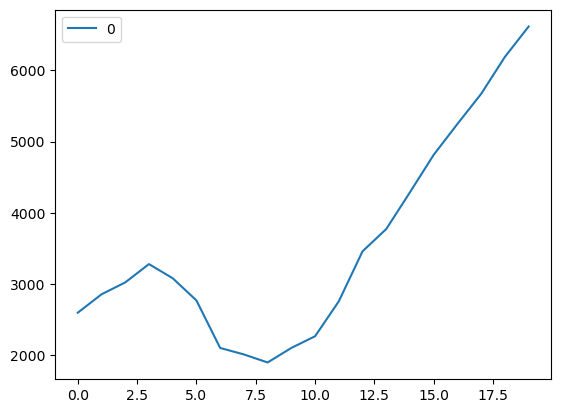

In [110]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

# MLFlow Model Registration

1899.204128959495


Registered model 'baseline-knn-model' already exists. Creating a new version of this model...
2023/05/30 10:25:59 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: baseline-knn-model, version 6
Created version '6' of model 'baseline-knn-model'.


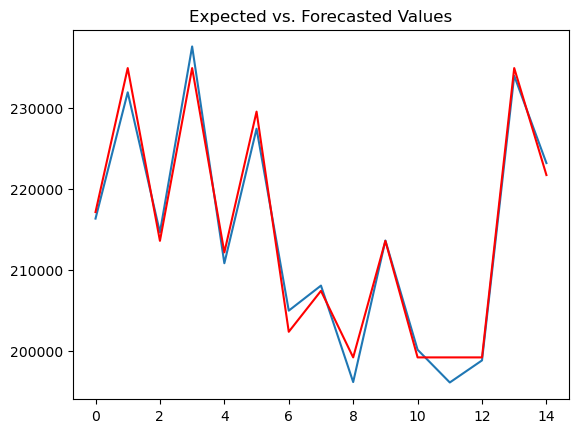

In [318]:
registered_model_name="baseline-knn-model"

with mlflow.start_run(run_name='knn'):
    
    # Log KNN Regressor with Optimal K Value (9)
    knn = KNeighborsRegressor(n_neighbors=9)

    knn.fit(x_train_scaled, y_train)
    pred = knn.predict(x_test_scaled)
    rmse = sqrt(mean_squared_error(y_test, pred))
    print(rmse)

    # infer model signature
    signature = infer_signature(x_test_scaled, pred)

    # log params
    mlflow.log_metric("rmse", rmse)    
    mlflow.sklearn.log_model(
        sk_model=knn,
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name=registered_model_name,
    )
    
    # plot/save actual vs. forecasted sales
    fig, ax = plt.subplots()
    plt.title("Expected vs. Forecasted Values")
    ax.plot(y_test)
    ax.plot(pred, color='red')
    mlflow.log_figure(fig, "expected_v_forecasted.png")

    mlflow.end_run()

In [163]:
# move existing model v2 to staging
client = MlflowClient()
client.transition_model_version_stage(
    name="baseline-knn-model", version=2, stage="Staging"
)

<ModelVersion: aliases=[], creation_timestamp=1685067877373, current_stage='Staging', description=None, last_updated_timestamp=1685119598517, name='baseline-knn-model', run_id='32fd47913200450db247671796063372', run_link=None, source='file:///C:/Users/Alex/Documents/Professional/Github%20Projects/retail_sales_forecasting/mlruns/678723752095675727/32fd47913200450db247671796063372/artifacts/sklearn-model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [164]:
# move existing model v4 to staging
client.transition_model_version_stage(
    name="baseline-knn-model", version=4, stage="Production"
)

<ModelVersion: aliases=[], creation_timestamp=1685112794504, current_stage='Production', description=None, last_updated_timestamp=1685119606123, name='baseline-knn-model', run_id='852a20e6223046a4bc8c85eac097c44e', run_link=None, source='file:///C:/Users/Alex/Documents/Professional/Github%20Projects/retail_sales_forecasting/mlruns/678723752095675727/852a20e6223046a4bc8c85eac097c44e/artifacts/sklearn-model', status='READY', status_message=None, tags={}, user_id=None, version=4>

# Batch Inference with Best Scoring Model

In [322]:
# retrieve the best saved model, register, and run batch inference
experiment = mlflow.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids = [experiment.experiment_id])
runs

metrics = [run.data.metrics["rmse"] for run in runs]
best_rmse = min(metrics)
best_run = [run for run in runs if run.data.metrics["rmse"] == best_rmse][0]
best_run.info

# Register the model from the best run and log it

model_name = "my_best_model"
mlflow.set_experiment(experiment_name=experiment_name)
model_uri = f"runs:/{best_run.info.run_id}/model"
model_version = mlflow.register_model(model_uri=model_uri, name=model_name)
model_version

Registered model 'my_best_model' already exists. Creating a new version of this model...
2023/05/30 10:40:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: my_best_model, version 4
Created version '4' of model 'my_best_model'.


<ModelVersion: aliases=[], creation_timestamp=1685457645446, current_stage='None', description=None, last_updated_timestamp=1685457645446, name='my_best_model', run_id='9512a9e827024cc8ad5708e054dc8d22', run_link=None, source='file:///C:/Users/Alex/Documents/Professional/Github%20Projects/retail_sales_forecasting/mlruns/678723752095675727/9512a9e827024cc8ad5708e054dc8d22/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=4>

In [226]:
# retrieve model 
model = client.get_registered_model(name=model_name)
model_artifact = mlflow.sklearn.load_model(model_uri)
model_artifact

# run batch inference
# pre-process data for model ingestion
latest_observation = 251622.12
updated_x_test = np.array(df.drop(columns=['sales_lag_50']).reset_index(drop=True).iloc[-1, :])

pred = model_artifact.predict(updated_x_test.reshape(1, -1))
pred

array([243040.67])

# Random Forest Model Performance Over Time

In [261]:
# create a scoring df that has actual and predicted values
scoring_df = feature_engineered_df.copy()
scoring_df['predicted_sales'] = rf.predict(np.array(feature_engineered_df.drop(columns=['sales']).reset_index(drop=True)))
scoring_df

,sales,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,...,sales_lag_42,sales_lag_43,sales_lag_44,sales_lag_45,sales_lag_46,sales_lag_47,sales_lag_48,sales_lag_49,sales_lag_50,predicted_sales
date,,,,,,,,,,,,,,,,,,,,,
1996-03,194029,192266.0,189135.0,190774.0,189055.0,186565.0,187366.0,186806.0,185431.0,186081.0,...,152588.0,151067.0,150761.0,149800.0,149010.0,148032.0,146805.0,147223.0,146925.0,194577.57
1996-04,194744,194029.0,192266.0,189135.0,190774.0,189055.0,186565.0,187366.0,186806.0,185431.0,...,153521.0,152588.0,151067.0,150761.0,149800.0,149010.0,148032.0,146805.0,147223.0,195059.54
1996-05,196205,194744.0,194029.0,192266.0,189135.0,190774.0,189055.0,186565.0,187366.0,186806.0,...,153583.0,153521.0,152588.0,151067.0,150761.0,149800.0,149010.0,148032.0,146805.0,195884.62
1996-06,196136,196205.0,194744.0,194029.0,192266.0,189135.0,190774.0,189055.0,186565.0,187366.0,...,155614.0,153583.0,153521.0,152588.0,151067.0,150761.0,149800.0,149010.0,148032.0,196001.12
1996-07,196187,196136.0,196205.0,194744.0,194029.0,192266.0,189135.0,190774.0,189055.0,186565.0,...,157555.0,155614.0,153583.0,153521.0,152588.0,151067.0,150761.0,149800.0,149010.0,196804.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12,588540,593090.0,601983.0,596156.0,596848.0,593870.0,597216.0,593988.0,594749.0,589238.0,...,448856.0,448869.0,445957.0,446084.0,438830.0,438377.0,435285.0,445484.0,443560.0,243278.09
2023-01,603211,588540.0,593090.0,601983.0,596156.0,596848.0,593870.0,597216.0,593988.0,594749.0,...,452442.0,448856.0,448869.0,445957.0,446084.0,438830.0,438377.0,435285.0,445484.0,243278.09
2023-02,600669,603211.0,588540.0,593090.0,601983.0,596156.0,596848.0,593870.0,597216.0,593988.0,...,455725.0,452442.0,448856.0,448869.0,445957.0,446084.0,438830.0,438377.0,435285.0,243278.09


In [245]:
rmse = sqrt(mean_squared_error(scoring_df['sales'], scoring_df['prediction']))
print(f'RMSE: {rmse}')

RMSE: 870.2093500575926


In [269]:
# view model performance over time
# ASSUMPTIONS: we trained the model in February 2001 and used historical data between January 1992 and January 2001, 
# the below model scoring over time will start (t1) in February 2001
rmse_list = []
for i in range (48, 327):    
    rmse = sqrt(mean_squared_error(scoring_df['sales'].iloc[:i], scoring_df['predicted_sales'].iloc[:i]))
    rmse_list.append(rmse)

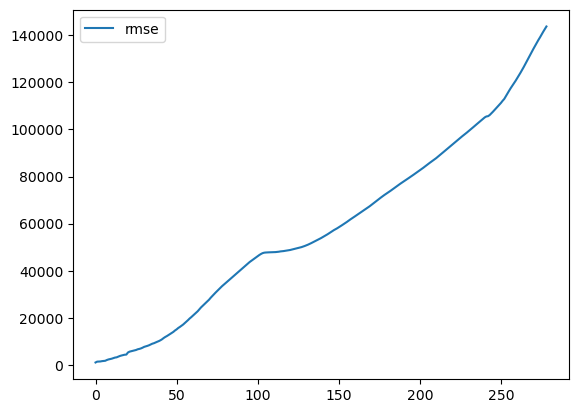

In [270]:
rmse_scoring_df = pd.DataFrame({'rmse': pd.Series(rmse_list)})

rmse_scoring_df.plot()
plt.show()

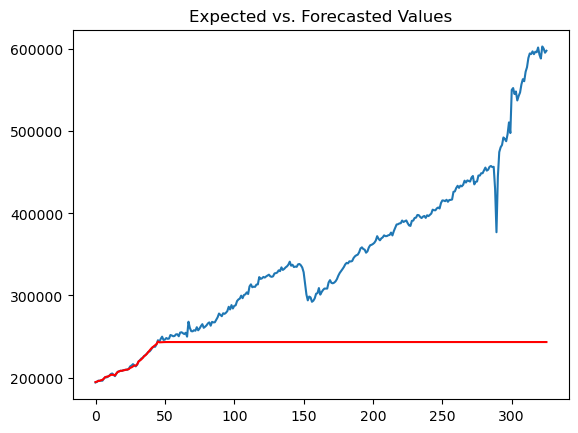

In [284]:
# plot/save actual vs. forecasted sales
plot_df = scoring_df.reset_index(drop=True)
plt.title("Expected vs. Forecasted Values")
plt.plot(plot_df['sales'])
plt.plot(plot_df['predicted_sales'], color='red')

# NOTE: based on the below plot, we can see that the random forest model is predicting the same value around t50 and beyond

In [312]:
# look at the 10 highest thresholds for each tree in the random forest model
thres = np.unique([j for i in rf.estimators_ for j in i.tree_.threshold])
np.sort(thres)[-10:]

# NOTE: the below is a likely indicator that the thresholds vs. observed values are leading to the same predicted value.
# Our future observed values are greater than the values used to train the model.

array([230136. , 230470. , 231569. , 232925.5, 234234.5, 235257. ,
       235714.5, 238555. , 239716.5, 243014.5])

# KNN Regressor Model Performance Over Time

In [319]:
knn_scoring_df = feature_engineered_df.copy()
knn_scoring_df['predicted_sales'] = knn.predict(np.array(feature_engineered_df.drop(columns=['sales']).reset_index(drop=True)))
knn_scoring_df

,sales,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,...,sales_lag_42,sales_lag_43,sales_lag_44,sales_lag_45,sales_lag_46,sales_lag_47,sales_lag_48,sales_lag_49,sales_lag_50,predicted_sales
date,,,,,,,,,,,,,,,,,,,,,
1996-03,194029,192266.0,189135.0,190774.0,189055.0,186565.0,187366.0,186806.0,185431.0,186081.0,...,152588.0,151067.0,150761.0,149800.0,149010.0,148032.0,146805.0,147223.0,146925.0,234892.333333
1996-04,194744,194029.0,192266.0,189135.0,190774.0,189055.0,186565.0,187366.0,186806.0,185431.0,...,153521.0,152588.0,151067.0,150761.0,149800.0,149010.0,148032.0,146805.0,147223.0,234892.333333
1996-05,196205,194744.0,194029.0,192266.0,189135.0,190774.0,189055.0,186565.0,187366.0,186806.0,...,153583.0,153521.0,152588.0,151067.0,150761.0,149800.0,149010.0,148032.0,146805.0,234892.333333
1996-06,196136,196205.0,194744.0,194029.0,192266.0,189135.0,190774.0,189055.0,186565.0,187366.0,...,155614.0,153583.0,153521.0,152588.0,151067.0,150761.0,149800.0,149010.0,148032.0,234892.333333
1996-07,196187,196136.0,196205.0,194744.0,194029.0,192266.0,189135.0,190774.0,189055.0,186565.0,...,157555.0,155614.0,153583.0,153521.0,152588.0,151067.0,150761.0,149800.0,149010.0,234892.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12,588540,593090.0,601983.0,596156.0,596848.0,593870.0,597216.0,593988.0,594749.0,589238.0,...,448856.0,448869.0,445957.0,446084.0,438830.0,438377.0,435285.0,445484.0,443560.0,234892.333333
2023-01,603211,588540.0,593090.0,601983.0,596156.0,596848.0,593870.0,597216.0,593988.0,594749.0,...,452442.0,448856.0,448869.0,445957.0,446084.0,438830.0,438377.0,435285.0,445484.0,234892.333333
2023-02,600669,603211.0,588540.0,593090.0,601983.0,596156.0,596848.0,593870.0,597216.0,593988.0,...,455725.0,452442.0,448856.0,448869.0,445957.0,446084.0,438830.0,438377.0,435285.0,234892.333333


In [320]:
# view model performance over time
# ASSUMPTIONS: we trained the model in February 2001 and used historical data between January 1992 and January 2001, 
# the below model scoring over time will start (t1) in February 2001
rmse_list = []
for i in range (48, 327):    
    rmse = sqrt(mean_squared_error(knn_scoring_df['sales'].iloc[:i], knn_scoring_df['predicted_sales'].iloc[:i]))
    rmse_list.append(rmse)

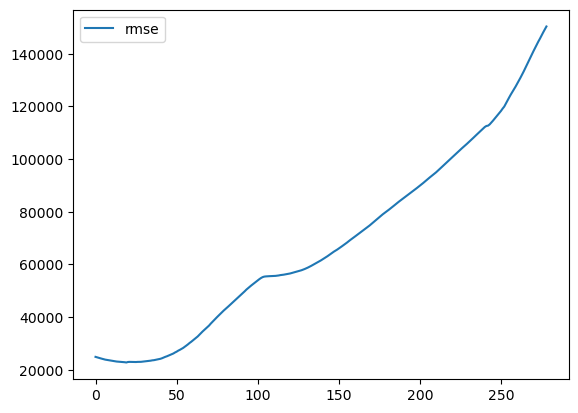

In [321]:
rmse_scoring_df = pd.DataFrame({'rmse': pd.Series(rmse_list)})

rmse_scoring_df.plot()
plt.show()

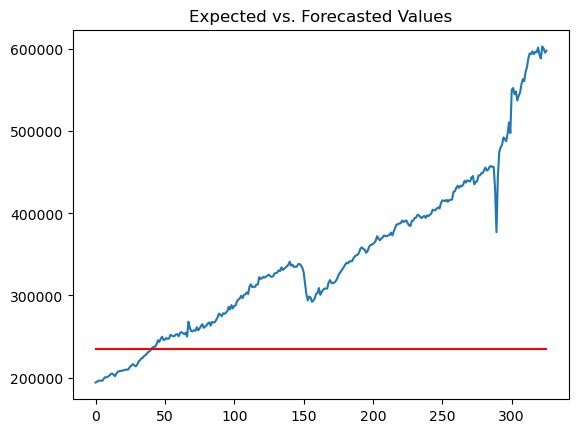

In [316]:
# plot/save actual vs. forecasted sales
plot_df = knn_scoring_df.reset_index(drop=True)
plt.title("Expected vs. Forecasted Values")
plt.plot(plot_df['sales'])
plt.plot(plot_df['predicted_sales'], color='red')

# Takeaways:
#### * For the given data and time-series analysis, a machine learning approach is not suitable
#### * The models trained on a random sample are not generalizable for future observed data, leading to largely increasing RMSE values over time
#### * Predictions on future data are not accurate as observed values are greater than the values used to train the model
#### * Training a new model when new monthly data is available may yield better/more accurate results but isn't the most efficient or generalizable approach
#### * Using a statistical approach (ARIMA) may yield better results by producing a better generalized model